# Optimisation of XGBoost learning rates (regularisation)

## Plain English Summary

As the feature for hospital ID is represented in the model as a one-hot encoded feature, and there are 132 hospitals, it is possible that the effect of hospitals ID becomes 'regularised out'. Learning rate in XGBoost acts as a regulariser. The lower the learning rate the less weight new trees have, and so the model becomes more regularised (less likely to overfit). 

Here we optimise the learning rate to maximise accuracy while maintaining the effect of hospital ID.

A learning rate of 0.5 is selected.

## Model and data
For each of the learning rate values, train an XGBoost model on all the data except the holdback 10k cohort.

Pass the 10k cohort through each learning rate model, sending all 10k patients to each of the hospitals. 

Record the thrombolysis rate for each hospital for each learning rate value. 

The 10 features in the model are:
* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Did the patient receive thrombolysis (0 = No, 1 = Yes)

## Aim
* Choose a learning rate that trains a model that maximises accuracy while maintaining the effect of hosptial ID.

## Observations
* Learning rates of less than 0.5 reduce the effect of hospital ID on 10k thrombolysis rates; the predicted thrombolysis rates are pulled closer to the mean thrombolysis rate.
* Standard deviation of 10k thrombolysis rate increases with learning rate, but is near-maximal at learning rate of 0.5
* Test set accuracy drops a little above learning rates of 0.25, but the effect is minimal at learning rate 0.5 (accuracy of 84.8% vs 84.9% at learning rate of 0.25).
* A learning rate of 0.5 is selected to balance accuracy and maintaining the effect of hospital ID on thrombolysis rate.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

## Set filenames

In [2]:
# Set up strings (describing the model) to use in filenames
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '91'

## Create output folders if needed

In [3]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Load data
Restrict to key features

In [4]:
data_loc = '../data/10k_training_test/'

train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
key_features.append('S2Thrombolysis')

# Restrict to key features
train = train[key_features]
test = test[key_features]

## Fit XGBoost model

For each of the learning rate values an XGBoost model is trained on the training set. Pass the 10k cohort (test set) through each learning rate model, sending all patients to each of the hospitals. Record the thrombolysis rate for each hospital for each learning rate value.

In [5]:
# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)

# Define the learning rates values to use
learning_rates = [0.1, 0.25, 0.5, 0.75, 1.0]

# Initialise the dictionary to store model results
thrombolysis_rates_by_lr = dict()

# List of hospital names
hospitals = list(set(train['StrokeTeam']))
hospitals.sort()

# Loop through learning rates
for lr in learning_rates:

    # Define model
    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=lr)

    # Fit model
    model.fit(X_train, y_train)

    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    y_pred = y_probs > 0.5

    # Show accuracy
    accuracy = np.mean(y_pred == y_test)
    print (f'Learning rate: {lr}. Accuracy: {accuracy:0.3f}')
    
    # Initialise lists
    thrombolysis_rate = []
    single_predictions = []

    # Loop through hospitals, pass 10k cohort through all hospital models and 
    #   get thrombolysis rate
    for hospital in hospitals:

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)

        # Copy hospital dataframe and change hospital ID (after setting all to zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)

        # Get predicted probabilities and class
        y_probs = model.predict_proba(X_test_adjusted)[:,1]
        y_pred = y_probs > 0.5
        
        # Add hospitals thrombolysis rate for this learning rate
        thrombolysis_rate.append(y_pred.mean())
    
    # Store all the hospitals thrombolysis rates for this learning rate
    thrombolysis_rates_by_lr[lr] = thrombolysis_rate   

Learning rate: 0.1. Accuracy: 0.843
Learning rate: 0.25. Accuracy: 0.849
Learning rate: 0.5. Accuracy: 0.848
Learning rate: 0.75. Accuracy: 0.843
Learning rate: 1.0. Accuracy: 0.835


## Plot histograms of 10k thrombolysis rates, depending on XGBoost learning rate

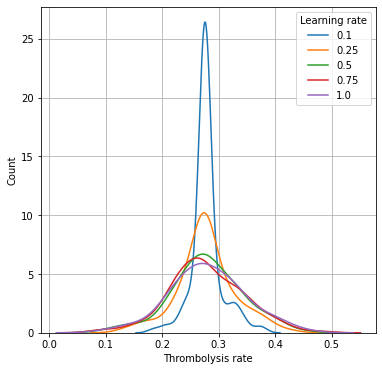

In [6]:
# Set up chart
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
for k, v in thrombolysis_rates_by_lr.items():
    sns.distplot(v, label=k, hist=False, ax=ax)
ax.legend(title='Learning rate')
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
ax.grid()
plt.savefig(f'./output/{notebook}_learning_rate.jpg', dpi=300)
plt.show()

## Show key data for 10k thrombolysis rates, depending on XGBoost learning rate

In [7]:
results = dict()
for k, v in thrombolysis_rates_by_lr.items():
    mean = np.mean(v)
    stdev = np.std(v)
    minimum = np.min(v)
    maximum = np.max(v)
    results[k] = [mean, stdev, minimum, maximum]
    
results = pd.DataFrame(results, 
                       index=['Mean', 'StdDev', 'Min', 'Max'])

results

,0.10,0.25,0.50,0.75,1.00
Mean,0.279060,0.278257,0.279636,0.278680,0.280369
StdDev,0.026747,0.050928,0.063063,0.065618,0.067114
Min,0.184300,0.131300,0.101000,0.091700,0.088800
Max,0.378400,0.429000,0.452700,0.476900,0.462300
